## Introduction
In this notebook we will work with the Exploration Wellbore Dataset from Norwegian Petroleum Directorate (NPD). The wellbore datasets are public domain. They are available here: https://data.norge.no/data/oljedirektoratet/br%C3%B8nnbane-wellbore. <br>

We will generate several stack bar graphs, using the ALTAIR library. The graphs will show us:
1. Status of all Exploration wells on the Norwegian Shelf since beginning of exploration, by year, number of wells and well content (oil/gas/condensate or any combination)
2. Status of Exploration wells between 1980 and 2019, by region: NORTH SEA, NORWEGIAN SEA and BARENTS SEA

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import altair as alt
# add the line below if you use notebooks and comment it if you use jupyter lab
# alt.renderers.enable('notebook')

#### API connection - check for status
Make a general get request, print out status code.
Status code = 200 means API connection is up and running.

In [2]:
requests.get('http://data.norge.no/api/dcat/870917732/data.json')

<Response [200]>

#### Get request - Exploration dataset
The datasets are paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset.

In [3]:
dataset_explo = requests.get('http://hotell.difi.no/api/json/npd/wellbore/exploration?page=1')
json_dataset_explo = dataset_explo.json()

In [4]:
print(f'number of pages: {json_dataset_explo["pages"]}')
print(f'number of rows:  {json_dataset_explo["posts"]}')

number of pages: 20
number of rows:  1930


#### Let's go through all the pages and append all the rows in JSON dictionary
Create a pandas dataframe from the json file

In [5]:
url_dataset ='http://hotell.difi.no/api/json/npd/wellbore/exploration'

def get_all_dataset():
    '''looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    
    page = json_dataset_explo['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_all_explo = pd.DataFrame(all_data_list)
    return df_all_explo

Redefine df_all_explo dataframe with output from function above

In [6]:
df_all_explo = get_all_dataset()
df_all_explo.shape

(1930, 87)

#### Select columns out in a new dataframe (from 81 columns down to 22)

In [7]:
# select only a few columns
df_all_explo_extract_col = df_all_explo.filter(['wlbWellboreName', 'wlbEwDesDeg','wlbNsDecDeg', 'wlbEntryYear',
                                                'wlbCompletionYear','wlbEwUtm','wlbNsUtm','wlbUtmZone',
                                                'wlbContent', 'wlbDiscoveryWellbore',
                                                'wlbTotalDepth','wlbAgeAtTd','wlbFormationAtTd',
                                                'wlbAgeWithHc1', 'wlbAgeWithHc2', 'wlbAgeWithHc3',
                                                'wlbFormationWithHc1', 'wlbFormationWithHc2', 'wlbFormationWithHc3',
                                                'wlbDrillingOperator', 'wlbMainArea', 'datesyncNPD'],
                                                axis=1)

In [8]:
df_all_explo_extract_col.head()

,wlbWellboreName,wlbEwDesDeg,wlbNsDecDeg,wlbEntryYear,wlbCompletionYear,wlbEwUtm,wlbNsUtm,wlbUtmZone,wlbContent,wlbDiscoveryWellbore,...,wlbFormationAtTd,wlbAgeWithHc1,wlbAgeWithHc2,wlbAgeWithHc3,wlbFormationWithHc1,wlbFormationWithHc2,wlbFormationWithHc3,wlbDrillingOperator,wlbMainArea,datesyncNPD
0,1/2-1,2.476583,56.887519,1989,1989,468106.29,6305128.26,31,OIL,YES,...,TOR FM,PALEOCENE,,,FORTIES FM,,,Phillips Petroleum Norsk AS,NORTH SEA,15.01.2020
1,1/2-2,2.496572,56.992222,2005,2006,469410.10,6316774.33,31,OIL SHOWS,NO,...,EKOFISK FM,,,,,,,Paladin Resources Norge AS,NORTH SEA,15.01.2020
2,1/3-1,2.851389,56.855833,1968,1968,490936.87,6301488.86,31,GAS,YES,...,ZECHSTEIN GP,LATE CRETACEOUS,EARLY CRETACEOUS,,TOR FM,CROMER KNOLL GP,,A/S Norske Shell,NORTH SEA,15.01.2020
3,1/3-2,2.750000,56.936111,1969,1969,484786.28,6310443.20,31,DRY,NO,...,SOLA FM,,,,,,,A/S Norske Shell,NORTH SEA,15.01.2020
4,1/3-3,2.981681,56.952378,1982,1983,498885.66,6312226.32,31,OIL,YES,...,ZECHSTEIN GP,LATE JURASSIC,,,ULA FM,,,Elf Petroleum Norge AS,NORTH SEA,15.01.2020


---

# Working with Altair bar graphs

#### Building a stack graph bar with exploration wells, grouped by well entry year (x axis), total number of well per year (y axis), and colour code for oil/gas/condensate/dry (or a combination of these)

In [9]:
# replace all empty values ('') in dataframe with 'nan'
df_all_explo_extract_col = df_all_explo_extract_col.replace('', np.nan)

In [10]:
df_all_explo_extract_col.shape

(1930, 22)

Let's check how many 'Wellbore Content' categories we have in the whole dataset, with a count per category:

In [11]:
df_all_explo_extract_col.wlbContent.unique()

array(['OIL', 'OIL SHOWS', 'GAS', 'DRY', 'GAS/CONDENSATE', 'SHOWS',
       'OIL/GAS', 'NOT APPLICABLE', 'GAS SHOWS', 'OIL/GAS SHOWS', nan,
       'OIL/GAS/CONDENSATE', 'NOT AVAILABLE'], dtype=object)

In [12]:
df_all_explo_extract_col['wlbContent'].nunique()

12

In [13]:
df_all_explo_extract_col[['wlbEntryYear','wlbContent']].groupby('wlbContent').agg(['count'])

,wlbEntryYear
,count
wlbContent,
DRY,507
GAS,151
GAS SHOWS,16
GAS/CONDENSATE,156
NOT APPLICABLE,47
NOT AVAILABLE,1
OIL,482
OIL SHOWS,75


In [14]:
# show how many 'NaN' entries for each column
df_all_explo_extract_col.isna().sum()

wlbWellboreName            0
wlbEwDesDeg                0
wlbNsDecDeg                0
wlbEntryYear               0
wlbCompletionYear          0
wlbEwUtm                   0
wlbNsUtm                   0
wlbUtmZone                 0
wlbContent                38
wlbDiscoveryWellbore       0
wlbTotalDepth             37
wlbAgeAtTd                80
wlbFormationAtTd         153
wlbAgeWithHc1            829
wlbAgeWithHc2           1519
wlbAgeWithHc3           1861
wlbFormationWithHc1      884
wlbFormationWithHc2     1538
wlbFormationWithHc3     1866
wlbDrillingOperator        0
wlbMainArea                0
datesyncNPD                0
dtype: int64

We are removing rows with 'NaN' in 'Wellbore Content'...

In [15]:
# removing all wlbContent with NaN
df_all_explo_extract_col = df_all_explo_extract_col[pd.notnull(df_all_explo_extract_col['wlbContent'])]

In [16]:
df_all_explo_extract_col.shape

(1892, 22)

#### Let's QC the years in our dataset - do we have any values for years which are not relevant?

In [17]:
# what is my minimum entry year?
df_all_explo_extract_col['wlbEntryYear'].min()

'0'

In [18]:
# what is my maximum entry year?
df_all_explo_extract_col['wlbEntryYear'].max()

'2019'

In [19]:
# how many entry years = 0?
df_all_explo_extract_col[df_all_explo_extract_col['wlbEntryYear'] == '0']

,wlbWellboreName,wlbEwDesDeg,wlbNsDecDeg,wlbEntryYear,wlbCompletionYear,wlbEwUtm,wlbNsUtm,wlbUtmZone,wlbContent,wlbDiscoveryWellbore,...,wlbFormationAtTd,wlbAgeWithHc1,wlbAgeWithHc2,wlbAgeWithHc3,wlbFormationWithHc1,wlbFormationWithHc2,wlbFormationWithHc3,wlbDrillingOperator,wlbMainArea,datesyncNPD
1318,35/9-4 SR,3.965342,61.325694,0,0,551677.16,6799609.42,31,NOT APPLICABLE,NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Statoil ASA (old),NORTH SEA,15.01.2020


#### We found one row with year = 0. Let's remove this row from our dataset.

In [20]:
# remove all rows with entry year = 0
df_all_explo_extract_col.drop(1318, inplace=True)

In [21]:
df_all_explo_extract_col.shape

(1891, 22)

In [22]:
# quick check:
df_all_explo_extract_col.iloc[1289:1294]

,wlbWellboreName,wlbEwDesDeg,wlbNsDecDeg,wlbEntryYear,wlbCompletionYear,wlbEwUtm,wlbNsUtm,wlbUtmZone,wlbContent,wlbDiscoveryWellbore,...,wlbFormationAtTd,wlbAgeWithHc1,wlbAgeWithHc2,wlbAgeWithHc3,wlbFormationWithHc1,wlbFormationWithHc2,wlbFormationWithHc3,wlbDrillingOperator,wlbMainArea,datesyncNPD
1315,35/9-2,3.937983,61.335728,1991,1991,550196.62,6800705.66,31,OIL/GAS,YES,...,BASEMENT,LATE JURASSIC,MIDDLE JURASSIC,NaN,SOGNEFJORD FM,FENSFJORD FM,NaN,Norsk Hydro Produksjon AS,NORTH SEA,15.01.2020
1316,35/9-3,3.975047,61.481044,1997,1997,551938.12,6816921.17,31,OIL/GAS,YES,...,BASEMENT,LATE CRETACEOUS,EARLY CRETACEOUS,NaN,KYRRE FM,AGAT FM,NaN,Norsk Hydro Produksjon AS,NORTH SEA,15.01.2020
1317,35/9-4 S,3.965342,61.325694,1998,1998,551677.16,6799609.42,31,NOT APPLICABLE,NO,...,LISTA FM,NaN,NaN,NaN,NaN,NaN,NaN,Norsk Hydro Produksjon AS,NORTH SEA,15.01.2020
1319,35/9-5,3.812553,61.324694,2010,2010,543499.70,6799386.69,31,DRY,NO,...,KROSSFJORD FM,NaN,NaN,NaN,NaN,NaN,NaN,Nexen Exploration Norge AS,NORTH SEA,15.01.2020
1320,35/9-6 S,3.692650,61.371192,2010,2010,537025.98,6804492.08,31,OIL/GAS,YES,...,LUNDE FM,LATE JURASSIC,MIDDLE JURASSIC,EARLY JURASSIC,INTRA HEATHER FM SS,BRENT GP,DUNLIN GP,RWE Dea Norge AS,NORTH SEA,15.01.2020


#### Let's clean out 'Wellbore Content' values 'NOT APPLICABLE', 'NOT AVAILABLE', 'SHOWS', 'WATER' to have a more readable graph

In [23]:
df_all_explo_extract_col = df_all_explo_extract_col[df_all_explo_extract_col['wlbContent'].
                                                    isin(['NOT APPLICABLE',
                                                          'SHOWS',
                                                          'WATER',
                                                          'NOT AVAILABLE']) == False]

df_all_explo_extract_col.shape

(1705, 22)

Let's first make sure that we always apply the same colours to the same Wellbore contents throughout our graphs

In [24]:
domain = ['DRY',
          'GAS',
          'GAS SHOWS',
          'GAS/CONDENSATE',
          'OIL',
          'OIL SHOWS',
          'OIL/GAS',
          'OIL/GAS SHOWS',
          'OIL/GAS/CONDENSATE'
         ]
range_ = ['#DCDCDC',
          '#F5740F',
          '#F5970F', 
          '#D4B057',
          '#189839', 
          '#37D05E',
          '#E7B4E8',
          '#EB58EE',
          '#BBD878'
         ]

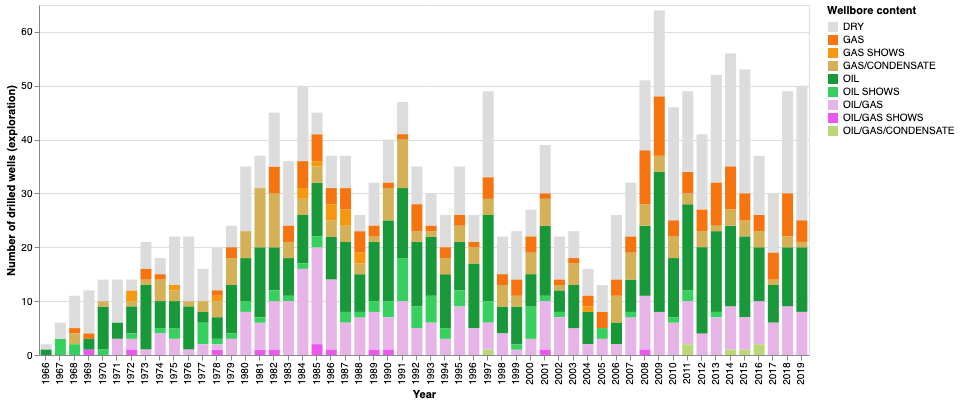

In [25]:
chart = (alt.Chart(df_all_explo_extract_col)
         .mark_bar(size=11)
         .encode(x=alt.X('wlbEntryYear:N',
                 axis=alt.Axis(title='Year')),
                 y=alt.Y('count()',
                 axis=alt.Axis(title='Number of drilled wells (exploration)')),
                 color=alt.Color('wlbContent',
                 scale=alt.Scale(domain=domain, range=range_),
                 legend=alt.Legend(title="Wellbore content"))
            ).properties(width=770, height=350)
        )
chart

---

#### Next, we would like to create three different bar graphs for North Sea, Norwegian Sea and Barents Sea, showing years 1980 to 2019

'wlbEntryYear' has type 'Object'. To be able to select years from 1980 to 2019, wlbEntryYear has to be converted in int64. <br><br>
Let's reduce the number of columns in the dataframe df_all_explo_extract_col and create a new dataframe df_all_explo_extract_col_years

In [26]:
df_all_explo_extract_col_years = df_all_explo_extract_col.filter(['wlbWellboreName','wlbEntryYear',
                                                'wlbCompletionYear',
                                                'wlbContent', 'wlbDiscoveryWellbore',
                                                'wlbTotalDepth','wlbAgeAtTd','wlbFormationAtTd',
                                                'wlbDrillingOperator', 'wlbMainArea', 'datesyncNPD'],
                                                axis=1)

In [27]:
df_all_explo_extract_col_years['wlbEntryYear'] = df_all_explo_extract_col_years['wlbEntryYear'].astype('int64')

In [28]:
# df_all_explo_extract_col_years.dtypes

---

Let's find out wlbEntryYear min and max for North Sea (NTS), Norwegian Sea (NS) and Barents Sea (BS

In [29]:
def wlbEntryYear():
    '''prints out start and end year for each region
    '''
    
    regions = ['NORTH SEA', 'NORWEGIAN SEA', 'BARENTS SEA']
    for region in regions:
        df_all_explo_extract_col_YYYY = df_all_explo_extract_col_years[
            df_all_explo_extract_col_years.wlbMainArea == region
        ]

        year_min = df_all_explo_extract_col_YYYY['wlbEntryYear'].min()
        year_max = df_all_explo_extract_col_YYYY['wlbEntryYear'].max()

        print(f'{region} Start year {year_min}\n{region} End year {year_max}')
    return

In [30]:
wlbEntryYear()

NORTH SEA Start year 1966
NORTH SEA End year 2019
NORWEGIAN SEA Start year 1980
NORWEGIAN SEA End year 2019
BARENTS SEA Start year 1980
BARENTS SEA End year 2019


We are going to focus on years 1980 to 2019 since this is the common time span available for all regions.

In [31]:
# select from df_all_explo_extract_col, years 1980 to 2019
df_all_explo_extract_col_1980_2019 = df_all_explo_extract_col_years.query('1980 <= wlbEntryYear <= 2019').copy()

In [32]:
df_all_explo_extract_col_1980_2019.shape

(1489, 11)

In [33]:
df_all_explo_extract_col_1980_2019.head()

,wlbWellboreName,wlbEntryYear,wlbCompletionYear,wlbContent,wlbDiscoveryWellbore,wlbTotalDepth,wlbAgeAtTd,wlbFormationAtTd,wlbDrillingOperator,wlbMainArea,datesyncNPD
0,1/2-1,1989,1989,OIL,YES,3574.0,CAMPANIAN,TOR FM,Phillips Petroleum Norsk AS,NORTH SEA,15.01.2020
1,1/2-2,2005,2006,OIL SHOWS,NO,3434.0,PALEOCENE,EKOFISK FM,Paladin Resources Norge AS,NORTH SEA,15.01.2020
4,1/3-3,1982,1983,OIL,YES,4876.0,LATE PERMIAN,ZECHSTEIN GP,Elf Petroleum Norge AS,NORTH SEA,15.01.2020
5,1/3-4,1983,1983,OIL SHOWS,NO,3198.0,LATE PERMIAN,ZECHSTEIN GP,Elf Petroleum Norge AS,NORTH SEA,15.01.2020
6,1/3-5,1984,1985,DRY,NO,4850.0,EARLY PERMIAN,ROTLIEGEND GP,A/S Norske Shell,NORTH SEA,15.01.2020


In [34]:
print(df_all_explo_extract_col_1980_2019['wlbEntryYear'].min())
print(df_all_explo_extract_col_1980_2019['wlbEntryYear'].max())

1980
2019


In [35]:
df_all_explo_extract_col_1980_2019.dtypes

wlbWellboreName         object
wlbEntryYear             int64
wlbCompletionYear       object
wlbContent              object
wlbDiscoveryWellbore    object
wlbTotalDepth           object
wlbAgeAtTd              object
wlbFormationAtTd        object
wlbDrillingOperator     object
wlbMainArea             object
datesyncNPD             object
dtype: object

In [36]:
# re-index df_all_explo_extract_col_1980_2019
df_all_explo_extract_col_1980_2019 = df_all_explo_extract_col_1980_2019.reset_index(drop=True)

Let's now create a new dataframe for each region (North Sea, Norwegian Sea and Barents Sea), and then create a graph for each.

In [37]:
df_all_explo_extract_col_1980_2019[['wlbWellboreName','wlbMainArea']].groupby('wlbMainArea').agg(['count'])

,wlbWellboreName
,count
wlbMainArea,
BARENTS SEA,139
NORTH SEA,1019
NORWEGIAN SEA,331


We can now draw a chart for each region, for years 1980 to 2019 (present)

In [38]:
def chart_region(region):
    ''' draw charts for each region
    '''
    
    df_all_explo_extract_col_1980_2019_reg = df_all_explo_extract_col_1980_2019[df_all_explo_extract_col_1980_2019[
                                            'wlbMainArea'].str.match(region)]
    chart=alt.Chart(df_all_explo_extract_col_1980_2019_reg).mark_bar(size=13).encode(
        x=alt.X('wlbEntryYear:N', axis=alt.Axis(title='Year')),
        y=alt.Y('count()', axis=alt.Axis(title='Number of drilled wells (exploration)')),
        color=alt.Color('wlbContent', scale=alt.Scale(domain=domain, range=range_),
       legend=alt.Legend(title=region + ' Wellbore content'))
        ).properties(width=700, height=300
        )
    return chart

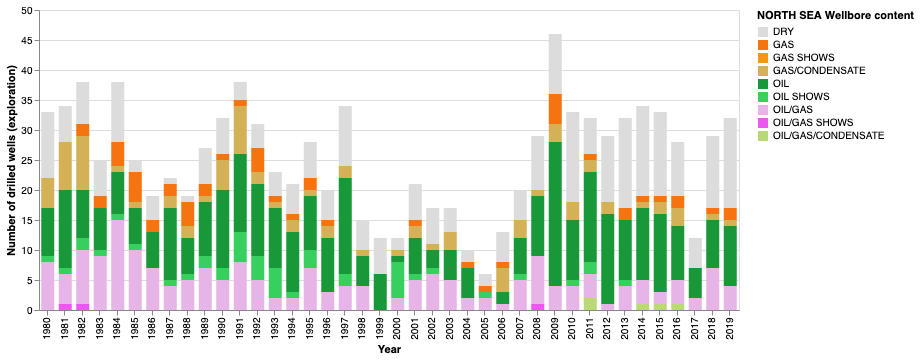

In [39]:
chart_region('NORTH SEA')

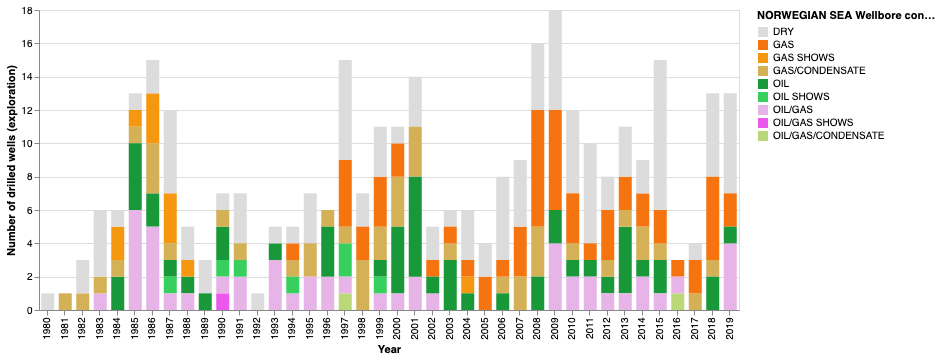

In [40]:
chart_region('NORWEGIAN SEA')

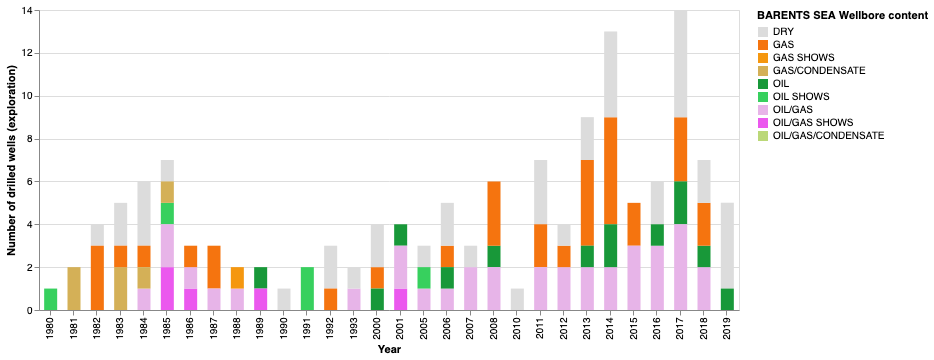

In [41]:
chart_region('BARENTS SEA')